In [1]:
import yfinance as yf

In [2]:
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
from matplotlib import dates
from datetime import datetime
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification, classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn import neural_network
import warnings
warnings.filterwarnings('ignore')

C:\Users\MyLenovo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
SPY = yf.Ticker("MSFT")

# get stock info
SPY.info

# get historical market data
hist = SPY.history(period="max")

In [4]:
df_drop = hist.drop('Dividends', axis=1)
df = df_drop.drop('Stock Splits', axis=1)

In [5]:
df=df.reset_index()
df

,Date,Open,High,Low,Close,Volume
0,1986-03-13,0.055898,0.064119,0.055898,0.061378,1031788800
1,1986-03-14,0.061378,0.064667,0.061378,0.063570,308160000
2,1986-03-17,0.063570,0.065215,0.063570,0.064667,133171200
3,1986-03-18,0.064667,0.065215,0.062474,0.063022,67766400
4,1986-03-19,0.063022,0.063570,0.061378,0.061926,47894400
...,...,...,...,...,...,...
9033,2022-01-12,319.670013,323.410004,317.079987,318.269989,34372200
9034,2022-01-13,320.470001,320.880005,304.000000,304.799988,45366000
9035,2022-01-14,304.250000,310.820007,303.750000,310.200012,39823500
9036,2022-01-18,304.070007,309.799988,301.739990,302.649994,42333200


In [6]:
OHLC_avg = df[['Close', 'Open', 'High', 'Low']].mean(axis = 1)

OHLC_avg

0         0.059324
1         0.062748
2         0.064256
3         0.063845
4         0.062474
           ...    
9033    319.607498
9034    312.537498
9035    307.255005
9036    304.564995
9037    307.152504
Length: 9038, dtype: float64

In [7]:
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1))
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

In [8]:
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [9]:
step_size = 1

In [10]:
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

In [11]:
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [12]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [13]:
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=1)

Epoch 1/5
6776/6776 [==============================] - 32s 4ms/step - loss: 3.2293e-05: 0s - l
Epoch 2/5
6776/6776 [==============================] - 31s 5ms/step - loss: 2.0579e-06
Epoch 3/5
6776/6776 [==============================] - 37s 5ms/step - loss: 2.0188e-06
Epoch 4/5
6776/6776 [==============================] - 46s 7ms/step - loss: 1.8985e-06
Epoch 5/5
6776/6776 [==============================] - 52s 8ms/step - loss: 1.6749e-06


In [14]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [15]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [16]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Train RMSE: 0.29
Test RMSE: 33.67


In [17]:
 mean_absolute_error(trainY[0],trainPredict[:,0])

0.208852933452014

In [18]:
explained_variance_score(trainY[0],trainPredict[:,0])

0.9992578402227488

In [19]:
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [20]:
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

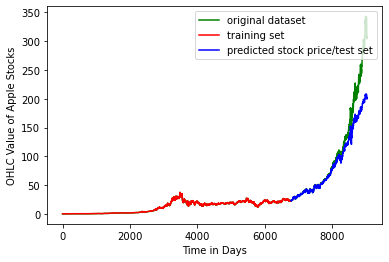

In [21]:
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.show()

In [22]:
model3=Sequential()
model3.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model3.add(LSTM(16))
model3.add(Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam') 

new_OHLC_avg=OHLC_avg.copy()

for i in range(5):
    trainX3, trainY3=new_dataset(new_OHLC_avg, 1)
    trainX3 = np.reshape(trainX3, (trainX3.shape[0], 1, trainX3.shape[1]))
    model3.fit(trainX3, trainY3, epochs=5, batch_size=1, verbose=2)
    
    last_val = new_OHLC_avg[-1]
    next_val = model3.predict(np.reshape(last_val, (1,1,1)))
    new_OHLC_avg = np.append(new_OHLC_avg, next_val[0])
    new_OHLC_avg=new_OHLC_avg.reshape(-1,1)

Epoch 1/5
9036/9036 - 65s - loss: 3146.2849 - 65s/epoch - 7ms/step
Epoch 2/5
9036/9036 - 43s - loss: 1990.5133 - 43s/epoch - 5ms/step
Epoch 3/5
9036/9036 - 37s - loss: 1342.8114 - 37s/epoch - 4ms/step
Epoch 4/5
9036/9036 - 35s - loss: 906.2429 - 35s/epoch - 4ms/step
Epoch 5/5
9036/9036 - 42s - loss: 623.3356 - 42s/epoch - 5ms/step
Epoch 1/5
9037/9037 - 31s - loss: 443.1428 - 31s/epoch - 3ms/step
Epoch 2/5
9037/9037 - 25s - loss: 319.3717 - 25s/epoch - 3ms/step
Epoch 3/5
9037/9037 - 38s - loss: 256.0388 - 38s/epoch - 4ms/step
Epoch 4/5
9037/9037 - 46s - loss: 188.7876 - 46s/epoch - 5ms/step
Epoch 5/5
9037/9037 - 46s - loss: 150.9383 - 46s/epoch - 5ms/step
Epoch 1/5
9038/9038 - 37s - loss: 120.5160 - 37s/epoch - 4ms/step
Epoch 2/5
9038/9038 - 37s - loss: 115.6483 - 37s/epoch - 4ms/step
Epoch 3/5
9038/9038 - 30s - loss: 79.4208 - 30s/epoch - 3ms/step
Epoch 4/5
9038/9038 - 30s - loss: 65.8114 - 30s/epoch - 3ms/step
Epoch 5/5
9038/9038 - 36s - loss: 79.5402 - 36s/epoch - 4ms/step
Epoch 1/5


In [23]:
next_val = scaler.inverse_transform(new_OHLC_avg[-90:])
OHLC_avg=scaler.inverse_transform(OHLC_avg)

In [24]:
df_new = pd.DataFrame(next_val)
df_old =  pd.DataFrame(OHLC_avg)

In [25]:
df_full = df_old.append(df_new)

In [26]:
df_reset = df_full.reset_index()
df_ful = df_reset.drop(['index'], axis=1)

In [27]:
df

,Date,Open,High,Low,Close,Volume
0,1986-03-13,0.055898,0.064119,0.055898,0.061378,1031788800
1,1986-03-14,0.061378,0.064667,0.061378,0.063570,308160000
2,1986-03-17,0.063570,0.065215,0.063570,0.064667,133171200
3,1986-03-18,0.064667,0.065215,0.062474,0.063022,67766400
4,1986-03-19,0.063022,0.063570,0.061378,0.061926,47894400
...,...,...,...,...,...,...
9033,2022-01-12,319.670013,323.410004,317.079987,318.269989,34372200
9034,2022-01-13,320.470001,320.880005,304.000000,304.799988,45366000
9035,2022-01-14,304.250000,310.820007,303.750000,310.200012,39823500
9036,2022-01-18,304.070007,309.799988,301.739990,302.649994,42333200


In [28]:
from matplotlib.pyplot import figure

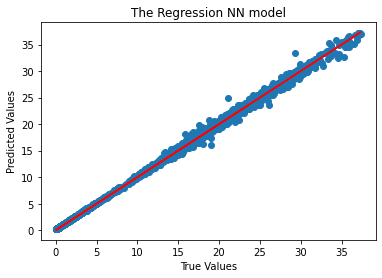

In [29]:
plt.scatter(trainY[0],trainPredict[:,0])
plt.plot(trainY[0],trainY[0],'r')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('The Regression NN model')
plt.show()

In [30]:
df_ful[-6:]

,0
9037,105463.968900
9038,101009.482799
9039,101286.242456
9040,101966.569829
9041,102549.211251
...,...
9123,53983.361747
9124,56784.715047
9125,57211.253617
9126,58344.196263


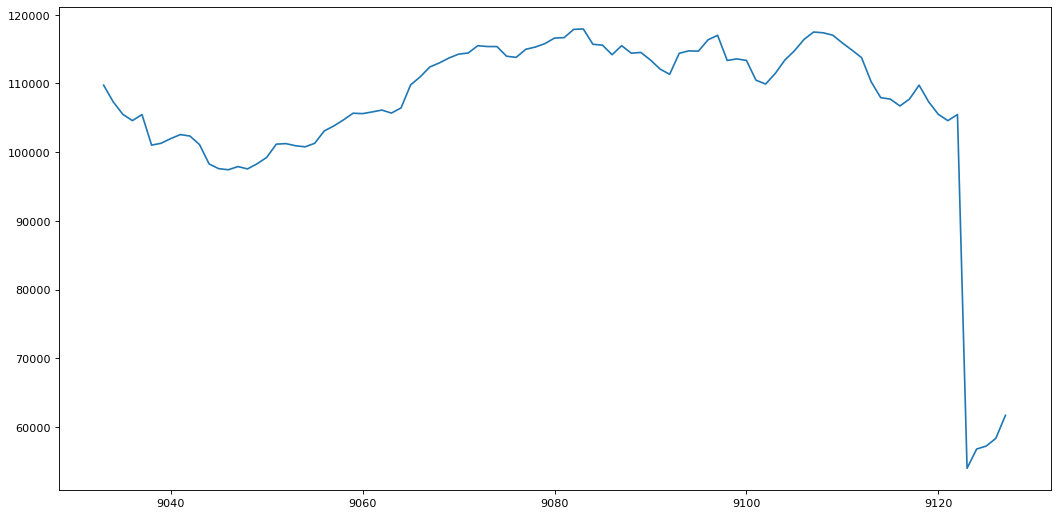

In [31]:
figure(figsize=(16, 8), dpi=80)
plt.plot(df_ful[-6:])

* Splitting the data into testing and training, with 2/3 for training and 1/3 for testing:

X, y = df.drop('Close', axis=1), df['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

Shape of the data:

X_train.shape

Hyperparameter tuning using GridSearchCV and KerasClassifier

In [32]:
#def build_clf(unit):
  # creating the layers of the NN
    #ann = tf.keras.models.Sequential()
    #ann.add(tf.keras.layers.Dense(units=unit, activation='relu'))
    #ann.add(tf.keras.layers.Dense(units=unit, activation='relu'))
    #ann.add(tf.keras.layers.Dense(units=1))
    #ann.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])
    #return ann

object of KerasClassifier class

In [33]:
#model_grid = KerasClassifier(build_fn=build_clf)

In [34]:
#params={'nb_epoch':[200, 100, 600],'unit':np.arange(4,44,8)}

#gs = GridSearchCV(estimator=model_grid, param_grid=params, cv=10, verbose=0)
# now fit the dataset to the GridSearchCV object. 
#gs = gs.fit(X, y)

In [35]:
#best_params=gs.best_params_
#accuracy=gs.best_score_

Creating a Model:

model = Sequential()

model.add(Dense(40,activation='relu'))
model.add(Dense(40,activation='relu'))
model.add(Dense(40,activation='relu'))
model.add(Dense(40,activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

Training the Model:

To find the optimal number of epochs, we use the EarlyStopping function:


from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
#callbacks=[early_stop]

model.fit(x=X_train,y=y_train.values,validation_data=(X_test,y_test),
          verbose=0, batch_size=32, epochs=1000, callbacks=[early_stop])

Checking the model for overfitting:

losses = pd.DataFrame(model.history.history)
losses.plot()

Evaluation on Test Data:

predictions = model.predict(X_test)

print("Mean absolute error is", mean_absolute_error(y_test,predictions))
print("Mean squared error is", np.sqrt(mean_squared_error(y_test,predictions)))
print("The Variance explied by the models is", explained_variance_score(y_test,predictions))
print("The Average percentage error is", mean_absolute_error(y_test,predictions)/df['Close'].mean()*100)

Plot Our predictions vs Perfect predictions

plt.scatter(y_test,predictions)
plt.plot(y_test,y_test,'r')

Min & Max errors:

errors = y_test.values.reshape(3012, 1) - predictions
print(min(errors), max(errors))

Distribution of the errors:

sns.distplot(errors, bins=50)